In [2]:
import pandas as pd
from pathlib import Path
folder = Path('data')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rd_ticks = [1,33,65, 100, 137, 174, 214, 256]

# from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, Normalizer, StandardScaler

from scipy import odr
from scipy.optimize import curve_fit
from scipy.stats import percentileofscore

import statsmodels.api as sm

In [3]:
from scipy.special import expit

def inv_sigmoid(x, x0, k, b):
    return expit(k*(-x+x0))+b

def sigmoid(x, x0, k, b):
    return expit(k*(x+x0))+b

## Contents
*demonstration of data anlysis*

 - [Load in data](#Load-and-Clean)
   - `cap` cap % vs draft pick, fit from spotrac data
   - `draft` draft data, pick/position/performance from PFR
   - `data` market data, 2023 contracts from OTC
 - Define class and graph functions for data processing
   - [position value](#Position-Value-Class-Code)
     - position groupings defined
     - saved choices defined, must at least be empty dictionary!
   - [compare graphs](#Compare-Graphs-Code)
 - ~~[Position data demonstration](#Class-Demo)~~
   - try yourself, delete saved choices and try for any position
 - [Generate position data](#Run-Class-Code)
 - [Generate comparison graphs](#Comparison-Graphs)

### Load and Clean

In [4]:
cap_history = pd.read_csv(Path(folder, 'salary_cap_history.csv'), index_col=0)
max_cap = cap_history[cap_history.Year==2023].Cap.values[0]
del cap_history
print(max_cap)

# cap table, pick vs salary cap percentage
cap = pd.read_csv(Path(folder, 'pick_cap_percentage.csv'), index_col=0)
# draft table
draft = pd.read_csv(Path(folder, 'draft_2011-2023.csv'), index_col=0)
# salary data
data = pd.read_csv(Path(folder, 'vet_contracts.csv'), index_col=0)

224800000


In [5]:
# draft adjustments, 2011 and after for CB agreement --> wagescale
draft = draft[draft.draft_year >= 2011]
draft.drop(columns = draft.columns[13:27], inplace=True)
draft.drop(columns=draft.columns[draft.columns.str.startswith('Misc_')], inplace=True)
draft.rename(columns={'Approx Val_wAV':'wAV', 'Approx Val_DrAV':'dAV', 'G':'Games','Uni':'College'}, inplace=True)

# clean negatives | draft.loc[[2744,3295,4251],:]
draft.loc[draft[draft.dAV<0].index, 'dAV'] = 0
draft.loc[draft[draft.wAV<0].index, 'wAV'] = 0

# normalize value by games played
draft.loc[:,'wAVpG'] = draft['wAV']/draft['Games']
draft.loc[:,'dAVpG'] = draft['dAV']/draft['Games']
# fill na with 0
draft['wAVpG'] = draft['wAVpG'].fillna(0)
draft['dAVpG'] = draft['dAVpG'].fillna(0)

# Change "To" to years played
draft.loc[:,'To'] = draft['To']-draft['draft_year']+1
draft.rename(columns={'To':'Yrs', 'draft_year':'Drafted'}, inplace=True)
draft.loc[draft[draft.Yrs<=0].index, 'Yrs'] = 0

# Convert single Pos==OT (AJ Arcuri) to T
draft.loc[draft[draft.Pos=='OT'].index,'Pos'] = 'T'

# Add Cap Percentage
draft.loc[:,'Cap'] = draft['Pick'].map(lambda x: cap.loc[x, 'Perc'])

In [6]:
draft.sample(3)

,Rnd,Pick,Tm,Player,Pos,Age,Yrs,Yrs_Starter,wAV,dAV,Games,College,Drafted,wAVpG,dAVpG,Cap
1244,7,228,MIN,Austin Shepherd,T,23,1,0,1,1,14,Alabama,2015,0.071429,0.071429,0.329793
3241,5,177,LAR,Puka Nacua,WR,22,1,0,14,14,17,BYU,2023,0.823529,0.823529,0.341419
2543,7,255,NYG,Tae Crowder,LB,23,4,2,16,16,43,Georgia,2020,0.372093,0.372093,0.323638


In [7]:
data.sample(3)

,Player,Pos,Tm,Total Value,APY,Total Guaranteed,AGY,% Guaranteed,APY_Cap
2213,Sincere McCormick,RB,Raiders,795000,795000,0,0,0.0,0.354
385,Patrick Mekari,LT,Ravens,15450000,5150000,7100000,2366667,46.0,2.291
1901,Micah Baskerville,LB,Bears,915000,915000,0,0,0.0,0.407


### Position Value Class Code

In [6]:
saved_choices = {
    'WR':(5,1), # poly, gamma
    'RB':(4,1), # sigmoid, gamma
    'QB':(3,2), # gamma, poisson
    'TE':(4,2), # sigmoid, poisson
    'DB':(5,3), # poly, invgaussian
    'ST':(2,1), # nbinom, gamma
    'OT':(3,1), #  gamma, gamma
    'iOL':(4,1) # sigmoid, gamma
}

pos_groups = {
    'DB':['CB','S','DB'],
    'ST':['K','P','FB','LS'],
    'iOL':['G','C'],
    'OT':['OT'],
}

import warnings
from statsmodels.tools.sm_exceptions import DomainWarning
warnings.simplefilter('ignore', DomainWarning)

In [7]:
class PosValueCalc:
    def __init__(self, position, draft_data=draft, market_data=data, rookie_cap=cap):
        self.position = position
        # default range for market rate searches, adjust later for groups
        self.top_contracts = 32 if self.position!='QB' else 19
        self.fit_info = {'draft':None, 'market':None}
        
        # allow for position groupings, adjust market range as needed
        if self.position == 'OT':
            # position label harmony
            market_data.loc[market_data[market_data.Pos.isin(['RT','LT'])].index,'Pos'] = 'OT'
            draft_data.loc[draft_data[draft_data.Pos=='T'].index,'Pos'] = 'OT' 
            # match draft OL to OT using market, drop rest
            ol_match = market_data[
                (market_data.Player.isin(draft_data[draft_data.Pos=='OL'].Player)) & 
                (market_data.Pos=='OT')].Player
            draft_data.loc[\
                draft[(draft_data.Player.isin(ol_match)) & 
                (draft_data.Pos=='OL')].index, 'Pos'] = 'OT'
        
        elif self.position == 'iOL':
            # position label harmony
            market_data.loc[market_data[market_data.Pos.isin(['RG','LG'])].index,'Pos'] = 'G'
            
            # match draft OL to OT using market, drop rest
            for iOL in ['G','C']:
                ol_match = market_data[
                    (market_data.Player.isin(draft_data[draft_data.Pos=='OL'].Player)) 
                    & (market_data.Pos==iOL)].Player
                draft_data.loc[
                        draft_data[(draft_data.Player.isin(ol_match)) 
                        & (draft_data.Pos=='OL')].index, 'Pos'] = iOL
            self.top_contracts=48
            
        elif self.position in pos_groups.keys():
            self.top_contracts*=2
        
        if self.position not in pos_groups.keys():
            self.position_group = [self.position] 
        else:
            self.position_group = pos_groups[self.position]
            
       
        # collect draft data for position (grouping)
        # AVpG percentile for performance metric
        self.draft_table = draft_data[draft_data.Pos.isin(self.position_group)]  
        pd.options.mode.chained_assignment = None
        self.draft_table.loc[:,'AV_percentile'] = \
            percentileofscore(self.draft_table.wAVpG, self.draft_table.wAVpG,).round(1)
        
        # Final Table: draft Cap vs draft Pick
        # add predicted performance, percentile from draft_fit_choice
        # add equivalent market rate from vet_market_choice
        self.final_table = rookie_cap.rename(columns={'Perc':'Rookie_Cap'})
        
        # choice for draft fit, AVpG vs Pick
        self.draft_fit_choice() # default poly fit order=3
        
        # gather market data for position, add AVpG from draft data
        self.market_table = self.market_data(market_data)
        # exclude rookie contracts (not perfect cutoff)
        # UDFAs also dropped, performance data not in draft table
        # players drafted prior to 2011 dropped, draft data cutoff due to CBA
        self.vet_market = self.market_table[self.market_table['Drafted']<=2020].dropna()
        # choice for market fit, AVpG percentile vs Cap
        self.vet_market_choice() # default polyfit order=4
        pd.options.mode.chained_assignment = 'warn'
        
        # save final graphs, tables
        # self.draft_surplus_graph(Path('position graphs')
        # self.market_premium_graph()
        
    def graphs(self):
        for plot in ['draft_fit_graph','vet_market_graph',
                     'draft_surplus_graph','market_premium_graph']:
            print(plot)
    def tables(self):
        for df in ['draft_table','market_table',
                   'vet_market','final_table']:
            print(df)
    
    def draft_curve_fits(self, deg):
        # data to fit
        d = self.draft_table.dropna()
        cutoff = d.Pick.max()+1 if self.position!='QB' else 260
        d = d[d.Pick<cutoff]
        # GLMs: Binom, NegBinom, Gamma  
        mx = sm.add_constant(d.Pick)
        fx1 = sm.GLM(d.wAVpG, mx, family=sm.families.Binomial()).fit()
        fx2 = sm.GLM(d.wAVpG, mx, family=sm.families.NegativeBinomial(alpha=1)).fit()
        # initialize gamma with: sm.families.links.Log() to avoid error
        fx3 = sm.GLM(d.wAVpG, mx, family=sm.families.Gamma()).fit()
        # Sigmoidal, Polyfit (default: 3rd order)
        popt, pcov = curve_fit(inv_sigmoid, d.Pick, d.wAVpG)
        sig_resid = np.sum((inv_sigmoid(d.Pick, *popt)-d.wAVpG)**2)
        px = np.polyfit(d.Pick, d.wAVpG, deg,  full=True)  
        
        return fx1, fx2, fx3, (popt,sig_resid), (px[0], px[1][0], deg)
     
    def draft_fit_graph(self, deg=3, user_choice=False, save=False):     
        plt.ion()
        # Binom, NegBinom, Gamma, Inv Sigmoid, Poly Fits
        fx1, fx2, fx3, sig_fit, poly_fit = self.draft_curve_fits(deg)
        sq_resp = np.sum(fx1._endog**2) # normalize error by response
        
        # Present Plot
        d = self.draft_table.dropna()
        fig, ax = plt.subplots(figsize=(8,5), dpi=100)
        ax.scatter(data = d, x='Pick', y='wAVpG', color='k', alpha=0.5, linewidths=0)
        
        x = np.linspace(1, d.Pick.max(), d.Pick.max())
        ax.plot(x, fx1.predict(sm.add_constant(x)),'-', linewidth=2, alpha=0.9)
        ax.plot(x, fx2.predict(sm.add_constant(x)),'-', linewidth=2, alpha=0.9)
        ax.plot(x, fx3.predict(sm.add_constant(x)),'-', linewidth=2, alpha=0.9)
        ax.plot(x, inv_sigmoid(x, *sig_fit[0]),'-', linewidth=2, alpha=0.9)
        ax.plot(x,np.poly1d(poly_fit[0])(x),'-', linewidth=2, alpha=0.9)
        
        ax.set_ylabel('AV per Game')
        ax.set_xlabel('Draft Pick')
        ax.set_xticks(rd_ticks)
        ax.grid(axis='x')
        ax.set_xlim([1,d.Pick.max()])
        title_text = f'Performance vs Draft | {self.position} Fit'
        if len(self.position_group)>1:
            title_text += f' {[p for p in self.position_group]}'
        ax.set_title(title_text, fontweight='bold')
        # plt.suptitle(f'top 3 of {d.shape[0]} picks labeled', y=0.87, x=0.87, ha='right',
        #               fontweight='bold',fontsize='small')
        ax.legend([
    f'{self.position} AVpG vs Draft Pick', 
    f'{str(fx1.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx1.resid_response**2)/sq_resp,2)}',
    f'{str(fx2.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx2.resid_response**2)/sq_resp,2)}',
    f'{str(fx3.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx3.resid_response**2)/sq_resp,2)}',
    f'Sigmoidal | {round(100*sig_fit[1]/sq_resp,2)}',
    f'{poly_fit[2]}d Poly | {100*round(poly_fit[1]/sq_resp,2)}',
                    ], 
               loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False)
        
        # Overall Best Picks
        for x,y,t,p in d.sort_values('wAVpG', ascending=False).head(3)[['Pick','wAVpG','Tm','Player']].values:
            ax.text(x,y,f"{p.split(' ')[-1]} ({t})",
                    ha='center', fontsize='small', fontweight='bold')
            
        # Best,Worst,On-Point Picks, only with fit
        if user_choice == False:
            pd.options.mode.chained_assignment = None
            score = d[['Pick','Tm','Player','wAVpG', 'fit_wAVpG']]
            score.loc[:,'AV_diff'] = score.wAVpG - score.fit_wAVpG
            score.sort_values('AV_diff', inplace=True)
            on_point = score.AV_diff.searchsorted(0)
            pd.options.mode.chained_assignment = 'warn'
            colors = ['r','m','g']
            for i,val in enumerate([0, on_point, score.shape[0]-1]):
                pick = score.iloc[val,:]
                ax.text(pick.Pick, pick.wAVpG, 
                        f"{pick.Player.split(' ')[-1]} ({pick.Tm})",
                        ha='center', fontsize='small', fontweight='bold',
                        color=colors[i])
        if save != False:
            plt.savefig(Path(save, 'draft fits', f'{self.position}_draft-fit.png'), bbox_inches='tight')
        
        plt.show()
        return
        
    def draft_fit_choice(self, deg=3):
        # Binom, NegBinom, Gamma, Inv Sigmoid, Poly Fits
        fx1, fx2, fx3, sig_fit, poly_fit = self.draft_curve_fits(deg)
        sq_resp = np.sum(fx1._endog**2)
        choices = [
            f'{str(fx1.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx1.resid_response**2)/sq_resp,3)}',
            f'{str(fx2.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx2.resid_response**2)/sq_resp,3)}',
            f'{str(fx3.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx3.resid_response**2)/sq_resp,3)}', 
            f'Sigmoidal | {round(100*sig_fit[1]/sq_resp,3)}', 
            f'{poly_fit[2]}d Poly | {round(100*poly_fit[1]/sq_resp,3)}',
                    ]
        
        if self.position not in saved_choices.keys():
            self.draft_fit_graph(deg=deg)
            print('\tChoose fit:')
            for i, choice in enumerate(choices):
                print(f'{i+1}.', '|', choice)
            selection = input()
            try:
                choice = int(selection)-1
            except:
                print("Invalid selection!")
                return
        else:
            choice = saved_choices[self.position][0]-1       
        print('Using', choices[choice])
        
        x = self.final_table.index
        x2 = self.draft_table.Pick
        if choice==0:
            AV_fit = fx1.predict(sm.add_constant(x))
            draft_fit  = fx1.predict(sm.add_constant(x2))
            fit_info = fx1.summary()
        elif choice==1:
            AV_fit = fx2.predict(sm.add_constant(x))
            draft_fit = fx2.predict(sm.add_constant(x2))
            fit_info = fx2.summary()
        elif choice==2:
            AV_fit = fx3.predict(sm.add_constant(x))
            draft_fit  = fx3.predict(sm.add_constant(x2))
            fit_info = fx3.summary()
        elif choice==3:
            AV_fit = inv_sigmoid(x, *sig_fit[0])
            draft_fit  =  inv_sigmoid(x2, *sig_fit[0])
            fit_info = ''.join([
    f"Parameters fit for sigmoid | AVpG=expit(k*(-PICK+x0))+b, where k={sig_fit[0][0]:.4e}, x0={sig_fit[0][1]:.4e}, and b={sig_fit[0][2]:.4e}",
    " | scipy docs: ", expit.__doc__.split('\n\n')[3].replace('\n', ' ')
                        ])
        elif choice==4:
            AV_fit = np.poly1d(poly_fit[0])(x)
            draft_fit = np.poly1d(poly_fit[0])(x2)
            fit_info = ''.join(
    [f'Parameters fit for polynomial({poly_fit[2]}) | AVpG='] +\
    [f'{"+" if i>0 and val>=0 else ""}{val:.4e}•PICK^{poly_fit[2]-i}' for i,val in enumerate(poly_fit[0])]
                        )
        
        self.final_table.loc[:,'pred_AV'] = AV_fit
        self.final_table.loc[:,'AV_percentile'] = percentileofscore(self.draft_table.dropna().wAVpG, AV_fit,).round(1)
        self.draft_table.loc[:, 'fit_wAVpG'] =  draft_fit 
        self.fit_info['draft'] = fit_info

    def market_data(self, market_data):
        # veteran salary cost
        d = market_data[market_data.Pos.isin(self.position_group)].sort_values('APY_Cap', ascending=False).head(self.top_contracts)
        
        # AVpG, Draft Year, Draft Pick from draft table
        d.loc[:,'AVpG'] = d.Player.map(lambda x: draft[(draft.Player==x) & (draft.Pos.isin(self.position_group))].wAVpG.values)
        d.loc[:,'AVpG'] = d.AVpG.map(lambda x: x[0] if len(x)>0 else None)

        d.loc[:,'Drafted'] = d.Player.map(lambda x: draft[(draft.Player==x) & (draft.Pos.isin(self.position_group))].Drafted.values)
        d.loc[:,'Drafted'] = d.Drafted.map(lambda x: int(x[0]) if len(x)>0 else None)
        
        d.loc[:,'Draft_Pick'] = d.Player.map(lambda x: draft[(draft.Player==x) & (draft.Pos.isin(self.position_group))].Pick.values)
        d.loc[:,'Draft_Pick'] = d.Draft_Pick.map(lambda x: int(x[0]) if len(x)>0 else None)
        
        # adjust dtypes, add percentile
        d.AVpG = d.AVpG.astype(float)
        d.loc[:,'AV_percentile'] = percentileofscore(self.draft_table.wAVpG, d.AVpG,).round(1)
        
        return d
    
    def vet_market_fits(self, deg):
        vet = self.vet_market
        # GLM fits: Gamma, Poisson, InvGaussian
        mx = sm.add_constant(vet.AV_percentile)
        # Gamma warning if not initialized with log link: sm.families.links.Log()
        fx1 = sm.GLM(vet.APY_Cap, mx, family=sm.families.Gamma()).fit()
        fx2 = sm.GLM(vet.APY_Cap, mx, family=sm.families.Poisson()).fit()
        fx3 = sm.GLM(vet.APY_Cap, mx, family=sm.families.InverseGaussian()).fit()
        # Polyfit (default: 2nd order), no Sigmoidal for now
        px = np.polyfit(vet.AV_percentile, vet.APY_Cap, deg,  full=True)
        
        return fx1, fx2, fx3, (px[0],px[1][0], deg)
        
    
    def vet_market_graph(self, deg=4, save=False):
        plt.ion()
        d = self.market_table
        vet = self.vet_market 
        # Gamma, Poisson, Inv Gaussian, Poly fits
        fx1, fx2, fx3, poly_fit = self.vet_market_fits(deg)
        sq_resp = np.sum(fx1._endog**2)
        # Present Plot
        fig, ax = plt.subplots(figsize=(8,5), dpi=100)
        sns.scatterplot(d.dropna(), y='APY_Cap', x='AV_percentile', hue='% Guaranteed', palette='bone',
                size='Total Value', legend=False, alpha=0.9, 
                edgecolor='k', linewidth=0.5, ax=ax)
        ax.scatter(data = d[~d.index.isin(vet.index)], x='AV_percentile', y='APY_Cap', 
                    color='m', alpha=0.5, linewidths=0)           
        xb = ax.get_xlim()
        yb = ax.get_ylim()
        x = np.linspace(xb[0], xb[1])
        
        ax.plot(x, fx1.predict(sm.add_constant(x)),'-',)
        ax.plot(x, fx2.predict(sm.add_constant(x)),'-',)
        ax.plot(x, fx3.predict(sm.add_constant(x)),'-',)
        ax.plot(x, np.poly1d(poly_fit[0])(x),'-',)
        
        title_text = f'Top {vet.shape[0]} Contracts vs Performance | {self.position} Fit'
        if len(self.position_group)>1:
            title_text += f' {[p for p in self.position_group]}'
        ax.set_title(title_text, fontweight='bold')
        
        ax.legend([
    f'{self.position} Vet Cap Hit vs Production', 'Rookie (not used for fit)',
    f'{str(fx1.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx1.resid_response**2)/sq_resp,2)}',
    f'{str(fx2.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx2.resid_response**2)/sq_resp,2)}',
    f'{str(fx3.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx3.resid_response**2)/sq_resp,2)}', 
    f'{poly_fit[2]}d Poly | {round(100*poly_fit[1]/sq_resp,2)}',
                    ], 
                    loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False)
        
        for ind in d.dropna().index:
            text_color = 'k' if ind in vet.index else 'm'
            ax.annotate(
                d.loc[ind,'Player'].split(' ')[1],
                (d.loc[ind,'AV_percentile'], d.loc[ind,'APY_Cap']+.1), 
                ha='center', color=text_color,
                        )
        ax.set_xlim(xb)
        ax.set_ylim(yb)
        if save != False:
            plt.savefig(Path(save, 'market fits', f'{self.position}_market-fit.png'), bbox_inches='tight')
        plt.show()
        return
        
    def vet_market_choice(self, deg=4):
        # Gamma, Poisson, Inv Gaussian, Sigmoid, Poly fits
        fx1, fx2, fx3, poly_fit = self.vet_market_fits(deg)
        sq_resp = np.sum(fx1._endog**2)
        choices = [
    f'{str(fx1.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx1.resid_response**2)/sq_resp,3)}',
    f'{str(fx2.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx2.resid_response**2)/sq_resp,3)}',
    f'{str(fx3.family.__class__).split(".")[-1][:-2]} | {round(100*np.sum(fx3.resid_response**2)/sq_resp,3)}',
    f'{poly_fit[2]}d Poly | {round(100*poly_fit[1]/sq_resp,3)}'
                    ]
        
        if self.position not in saved_choices.keys():
            self.vet_market_graph(deg=deg)
            print('\tChoose fit:')
            for i, choice in enumerate(choices):
                print(f'{i+1}.', '|', choice)
            selection = input()
            try:
                choice = int(selection)-1
            except:
                print("Invalid selection!")
                return
        else:
            choice = saved_choices[self.position][1]-1
        print('Using', choices[choice])
        
        x = self.final_table.AV_percentile
        x2 = self.vet_market.AV_percentile
        if choice==0:
            AV_fit = fx1.predict(sm.add_constant(x))
            vet_fit = fx1.predict(sm.add_constant(x2))
            fit_info = fx1.summary()
        elif choice==1:
            AV_fit = fx2.predict(sm.add_constant(x))
            vet_fit = fx2.predict(sm.add_constant(x2))
            fit_info = fx2.summary()
        elif choice==2:
            AV_fit = fx3.predict(sm.add_constant(x))
            vet_fit = fx3.predict(sm.add_constant(x2))
            fit_info = fx3.summary()
        elif choice==3:
            AV_fit = np.poly1d(poly_fit[0])(x)
            vet_fit = np.poly1d(poly_fit[0])(x2)
            fit_info = ''.join(
    [f'Parameters fit for polynomial({poly_fit[2]}) | AVpG='] +\
    [f'{"+" if i>0 and val>=0 else ""}{val:.4e}•PICK^{poly_fit[2]-i}' for i,val in enumerate(poly_fit[0])]
                        )
        
        self.final_table.loc[:,'Market_Cap'] = AV_fit.round(3)
        self.vet_market.loc[:,'fit_Cap'] = vet_fit.round(3)
        self.fit_info['market'] = fit_info
        
    def draft_surplus_graph_trace(self, ax, pick_cutoff=100):
        d = self.final_table.loc[1:pick_cutoff,:]
        # define surplus, find intersection with first pick
        pd.options.mode.chained_assignment = None
        d.loc[:,'Surplus'] = d.AV_percentile-d.Rookie_Cap*(d.Market_Cap)
        pd.options.mode.chained_assignment = 'warn'
        intersect = d.loc[2:,:][d.loc[2:,:].Surplus<=d.Surplus[1]]
        intersect = intersect.index[0] if intersect.empty==False else None       
        # market rate extrapolation
        market_bounds = (self.vet_market.AV_percentile.min(), self.vet_market.AV_percentile.max())
        d2 = d[d.AV_percentile.between(market_bounds[0], market_bounds[1])]
        peak = d2[d2.Surplus==d2.Surplus.max()].index[0]  
        
        
        # alternate definition, change intersect determination (see comparison graphs below)
        # should also change market premium to difference
        # d.loc[:,'Surplus'] = .01*d.AV_percentile*(d.Market_Cap-d.Rookie_Cap)
        # intersect = d.loc[3:,:][d.loc[3:,:].Surplus<=np.min(d.Surplus[0:3])]
        # intersect = intersect.index[0] if intersect.empty==False else None      
        
        # Surplus
        ax.plot(d2.index, d2.Surplus, 'k.-', linewidth=2)
        ax.plot(d.index, d.Surplus, 'k-', linewidth=1)
        if intersect:
            ax.fill(d.loc[1:intersect,'Surplus'].index, d.loc[1:intersect,'Surplus'], 
                     'aqua', alpha=0.2) 
            ax.text(intersect, d.loc[intersect,'Surplus'], intersect, 
                    color='aquamarine', fontsize='small', fontweight='bold',
                    backgroundcolor='k',ha='center',va='center', bbox={'boxstyle':'circle'})
        
        ax.text(peak, d2.loc[peak,'Surplus'], peak,
                color='teal', fontsize='small', fontweight='bold',
                ha='center',va='bottom')                
        
        ax.set_xticks(rd_ticks+[5,10])
        ax.grid(axis='x')
        # Market Premium
        ax2 = ax.twinx()
        ax2.plot(d2.index, d2.Market_Cap/d2.Rookie_Cap, 'r-', linewidth=2)
        ax2.plot(d.index, d.Market_Cap/d.Rookie_Cap, 'r:', linewidth=2)
        ax2.tick_params(axis='y', colors='r', direction='in',pad=-15)
        # Rookie Performance
        ax3 = ax.twinx()
        ax3.plot(d.index, d.AV_percentile, 'g-', linewidth=3)
        ax3.tick_params(axis='y', colors='g')

        title_text = f'Draft Surplus | {self.position}'
        if len(self.position_group)>1:
            title_text += f' {[p for p in self.position_group]}'
        ax.set_title(title_text, fontweight='bold')
        ax.set_xlabel('Draft Pick', fontweight='bold', fontsize='small')
        ax.set_ylabel('Draft Surplus', fontweight='bold', fontsize='small')
        
        y_text = np.mean(ax.get_ylim())
        y_step = 0.05*(ax.get_ylim()[1]-ax.get_ylim()[0])
        x_text = np.mean((1,pick_cutoff*0.1))
        ax.text(x_text, y_text-y_step*7,
                 'Draft Surplus', fontweight='bold')  
        ax.text(x_text, y_text-y_step*8,
                 'Rookie Production', color='g', fontweight='bold')
        ax.text(x_text, y_text-y_step*9,
                 'Market Premium', color='r', fontweight='bold') 
        return ax, ax2, ax3
    
    def draft_surplus_graph(self, fig_dpi=100, pick_cutoff=100, save=False):
        fig, ax = plt.subplots(figsize=(8,4), dpi=fig_dpi)
        ax = self.draft_surplus_graph_trace(ax, pick_cutoff=pick_cutoff)
        if save != False:
            plt.savefig(Path(save, 'draft surplus', f'{self.position}_draft-surplus.png'), bbox_inches='tight')
        plt.show()
        return
    
    def market_premium_graph_trace(self, ax):
        x = self.final_table
        x_d = self.draft_table
        x2 = self.vet_market.sort_values('fit_Cap')
        x3 = x[x.AV_percentile<x2.AV_percentile.min()] # within bounds

        # Draft Pred Performance vs Cap, Draft Rd Markings
        ax.plot(np.append(x2.AV_percentile.max(),x.AV_percentile.values),
                np.append(x.Rookie_Cap.max(),x.Rookie_Cap.values),
                '-', color='darkgreen', linewidth=3)
        ax.plot(x.loc[rd_ticks,'AV_percentile'].values, x.loc[rd_ticks,'Rookie_Cap'].values,
                 'X', color='limegreen', markersize=10, alpha=0.8)
        # Draft Actual Performance vs Cap
        ax.scatter(x_d.AV_percentile, x_d.Cap, color='g', 
                    alpha=0.3, linewidth=0)
        # Market Fit Performance vs Cap (mark out of bounds), Market Data
        ax.plot(x2.AV_percentile, x2.fit_Cap, '-', color='darkred')
        ax.plot(x2.AV_percentile, x2.APY_Cap, '.', color='darkred', markersize=7)
        ax.plot(x3.AV_percentile, x3.Market_Cap, '--', color='darkred')

        ax.set_xlabel('AVpG Percentile')
        ax.set_ylabel('Cap Percent')
        ax.set_xlim((x_d.AV_percentile.min()-1, x2.AV_percentile.max()+1))
        ax.grid(alpha=0.5)
        ax.legend(
            ['AVpG vs Draft Pick', 'Draft Rd Indicator',f'Draft Data [{x_d.shape[0]}]', 
            'Market Rate', f'Vet Contracts [{x2.shape[0]}]', 'AVpG < Market Min'],
            loc='upper left',ncols=1,frameon=False,
                  )
        title_text = f'Vet Market vs Rookie Cost | {self.position}'
        if len(self.position_group)>1:
            title_text += f' {[p for p in self.position_group]}'
        ax.set_title(title_text, fontweight='bold')

        # vet contract labels
        for ind in x2.sample(5).index:
            name = x2.loc[ind, 'Player']
            label = name # f"{name.split(' ')[0][0]}. {name.split(' ')[-1]}"
            draft_ind = x_d[x_d.Player==name].index.values[0]
            coords = (x_d.loc[draft_ind,'AV_percentile'], x2.loc[ind, 'APY_Cap'])
            start = x_d.loc[draft_ind,'Cap']
            ax.text(coords[0], coords[1]+.2, label, ha='center', fontsize='small',
                     fontweight='bold', alpha=0.8)
            ax.plot((coords[0],)*2, (start+.1,coords[1]-.1), 
                      '^-' if coords[1]-x2.loc[ind,'fit_Cap']>0 else 'v-',
                     color='k' if coords[1]-x2.loc[ind,'fit_Cap']>0 else 'lime',
                     markersize=2, linewidth=0.5, alpha=0.8)
        return ax
    
    def market_premium_graph(self, fig_dpi=100, save=False):
        fig, ax = plt.subplots(figsize=(8,4), dpi=fig_dpi)
        ax = self.market_premium_graph_trace(ax)
        if save != False:
            plt.savefig(Path(save, 'market premium', f'{self.position}_market-premium.png'), bbox_inches='tight')
        plt.show()
        return

### Class Demo
 - choosing fits, changing polynomial order

### Run Class Code
 - save graphs and tables

In [8]:
rb = PosValueCalc('RB')
wr  = PosValueCalc('WR')
qb  = PosValueCalc('QB')
te = PosValueCalc('TE')
db = PosValueCalc('DB')
st = PosValueCalc('ST')
ot = PosValueCalc('OT')
iol = PosValueCalc('iOL')

Using Sigmoidal | 22.999
Using Gamma | 6.497
Using 3d Poly | 30.295
Using Gamma | 6.044
Using Gamma | 24.006
Using Poisson | 1.613
Using Sigmoidal | 31.419


C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1806: RuntimeWarning: invalid value encountered in scalar subtract
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


Using Poisson | 5.741
Using 3d Poly | 24.833
Using InverseGaussian | 5.43
Using NegativeBinomial | 40.071


C:\Users\Nish\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Using Gamma | 3.825
Using Gamma | 18.703


C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:812: RuntimeWarning: divide by zero encountered in log
  ll_obs -= special.gammaln(weight_scale) + np.log(endog)
C:\Users\Nish\anaconda3\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1806: RuntimeWarning: invalid value encountered in scalar subtract
  prsq = 1 - np.exp((self.llnull - self.llf) * (2 / self.nobs))


Using Gamma | 3.653
Using Sigmoidal | 18.048
Using Gamma | 5.167


In [126]:
for pos in [rb,wr,qb,te,db,st,ot,iol]:
    # folder = Path('position graphs')
    # pos.draft_fit_graph(save=folder)
    # pos.vet_market_graph(save=folder)
    # pos.draft_surplus_graph(save=folder)
    # pos.market_premium_graph(save=folder)
    
    folder = Path('position tables')
    # pos.draft_table.to_csv(Path(folder, 'draft tables', f'{pos.position}_draft.csv'))
    pos.vet_market.to_csv(Path(folder, 'market tables', f'{pos.position}_market.csv'))
    # pos.final_table.to_csv(Path(folder, f'{pos.position}_final.csv'))

### Compare Graphs Code
 - all take save folder for optional argument
 - `position_compare`
   - input position classes, (pick bounds), dpi
 - `market_premium_compare`
   - input position classes, dpi
 - `draft_fit_compare`
   - input position classes, (pick bounds), dpi, box=True/False

In [10]:
def draft_fit_compare(*pos_classes, pick_bounds=(1,137), fig_dpi=100, box=False, save=False):
    plt.figure(figsize=(10,6), dpi=fig_dpi, layout='tight')
    colors = ['b','g','r','m','darkorange', 'turquoise', 'tan']
    pos_text = {}
    for i,p_class in enumerate(pos_classes):
        # [pick_bounds[0]:pick_bounds[1],:] 
        t = p_class.draft_table[p_class.draft_table.Pick.between(pick_bounds[0],pick_bounds[1])]\
                   .sort_values('fit_wAVpG')
        pd.options.mode.chained_assignment = None
        t.loc[:,'AV_diff'] = t.wAVpG - t.fit_wAVpG
        pd.options.mode.chained_assignment = 'warn'
        best = t[t.AV_diff==t.AV_diff.max()].index[0]
        worst = t[t.AV_diff==t.AV_diff.min()].index[0]

        if type(p_class.fit_info['draft']) == str:
            fit_function = p_class.fit_info['draft'].split(' | ')[0].split(' ')[-1].title()
        else:
            fit_function = p_class.fit_info['draft'].as_text().split('\n')[4:6]
            fit_function = [val.replace('  ','').split(' ')[2] for val in fit_function]
            fit_function = '_'.join(fit_function)

        pos_text[p_class.position] = f'{p_class.position} | {t.shape[0]} picks | {fit_function}'


        plt.plot(t.Pick, t.fit_wAVpG, '-', color=colors[i], linewidth=5)
        if box:
            m = np.linspace(t.Pick.min(),t.Pick.max(), int((t.Pick.max()-t.Pick.min())/3)).astype(int)
            ms = {m[i]: t[t.Pick.between(m[i], m[i+1])].wAVpG.values for i in range(m.shape[0]-1)}
            pb1 = plt.boxplot(x=ms.values(), positions=m[:-1], widths=m[1]-m[0], patch_artist=True, 
                              medianprops={'linewidth':0}, manage_ticks=False,
                              showcaps=False, zorder=0)
            plt.setp(pb1['whiskers'],color=colors[i], linewidth=2, alpha=0.3)
            plt.setp(pb1['fliers'], markeredgecolor=colors[i],markerfacecolor=colors[i], markersize=3,)
            plt.setp(pb1['boxes'], alpha=0.5, color=colors[i])
        else:
            plt.scatter(t.Pick, t.wAVpG,color=colors[i], alpha=0.4, linewidths=0, s=20)

        for pick in [best, worst]:
            pick = t.loc[pick,:]
            plt.text(pick.Pick, pick.wAVpG,  
                f"{pick.Player}\n({pick.Drafted} {pick.Tm})", alpha=0.8, va='center',
                ha='center', fontsize='small', fontweight='bold',
                color=colors[i])

    yb = plt.ylim()
    ystep = 0.05*(yb[1]-yb[0])
    xb = plt.xlim()
    xstep = 0.03*(xb[1]-xb[0])
    plt.text(xb[1]-xstep, yb[1], 
             f'Draft picks {pick_bounds[0]}-{pick_bounds[1]} | Curves fit to all data')
    for i,p_class in enumerate(pos_classes):
        plt.text(xb[1]-xstep, yb[1]-(i+1)*ystep, 
                 pos_text[p_class.position],  #
                 color=colors[i], fontweight='bold', ha='left')
    plt.xticks(rd_ticks+[5,10,20])
    plt.grid(axis='x', linewidth=1)
    plt.grid(axis='y', linewidth=0.4)
    plt.title('Draft Performance Fits | 2011-2023', fontweight='bold')
    plt.ylabel('AVpG', fontweight='bold', fontsize='small')
    plt.xlabel('Draft Pick', fontweight='bold', fontsize='small')
    plt.xlim(pick_bounds)
    
    if save != False:
        plt.savefig(Path(save, 'draft fit comparisons', 
                         f'draft-fit-compare_{",".join([p_class.position for p_class in pos_classes])}{"-box" if box==True else ""}.png'))

    plt.show()

In [9]:
def market_premium_compare(*pos_classes, fig_dpi=100, save=False):
    total = len(pos_classes)
    
    fig, axs = plt.subplots(
        nrows=1,ncols=total, sharey=True, layout='tight',
        figsize=(3+4*total, 5), dpi=fig_dpi,
                            )
    if total > 1:
        for i,val in enumerate(pos_classes):
            axs[i] = val.market_premium_graph_trace(axs[i])
            axs[i].tick_params(axis='y',labelleft=True)
    else:
        axs = pos_classes[0].market_premium_graph_trace(axs) 
        
    if save != False:
        plt.savefig(Path(save, 'market premium comparisons', 
                         f'market-premium-compare_{",".join([p_class.position for p_class in pos_classes])}.png'))
    plt.show()

In [23]:
def position_compare(*pos_classes, pick_bounds=(1,137), fig_dpi=100, save=False):
    plt.figure(figsize=(12,12), dpi=fig_dpi, layout='tight')
    colors = ['b','g','r','m','darkorange', 'turquoise', 'tan']
    pick_bounds = np.sort(pick_bounds)
    
    #    Row 1    |    Row 2    |
    #  Draft Fit  | Percentiles |
    #  Market Fit | Rate Compare|
    # Rate Premium| Draft Surplus|
    
    # Draft Performance vs Pick Fit
    ax = plt.subplot(321)
    for i,p_class in enumerate(pos_classes):
        t = p_class.final_table.loc[pick_bounds[0]:pick_bounds[1],:]  
        t2 = p_class.draft_table[p_class.draft_table.Pick.between(pick_bounds[0],pick_bounds[1])]
        err_x = []
        err_y = []
        for pick in t.index:
            match = p_class.draft_table[p_class.draft_table.Pick==pick]
            if match.shape[0] < 2:
                continue
            err_x.append(pick)
            err_y.append(np.abs(t.loc[pick,'AV_percentile']-match.AV_percentile.median())/2)
        plt.errorbar(err_x, t.loc[err_x,'AV_percentile'], err_y, ecolor=colors[i],
                     color=colors[i], alpha=0.2, elinewidth=4,
                     linewidth=0)    
        
        
        
    yb = plt.ylim()
    ystep = 0.05*(yb[1]-yb[0])
    xb = plt.xlim()
    xstep = 0.1*(xb[1]-xb[0])

    for i,p_class in enumerate(pos_classes):
        t = p_class.final_table.loc[pick_bounds[0]:pick_bounds[1],:]   
        plt.plot(t.index, t.AV_percentile,'-', 
                 color=colors[i], linewidth=3)
        pos_picks = p_class.draft_table[p_class.draft_table.Pick.between(pick_bounds[0],pick_bounds[1])].shape[0]
        plt.text(xb[1]-xstep, yb[1]-(i+1)*ystep, f' {pos_picks} {p_class.position} ━',  
                 color=colors[i], fontweight='bold', ha='right')

    
    plt.xticks(rd_ticks+[5,10,20])
    plt.grid(axis='x', linewidth=1)
    plt.title('Draft Performance Fits', fontweight='bold')
    plt.ylabel('Percentile AVpG', fontweight='bold', fontsize='small')
    plt.xlabel('Draft Pick', fontweight='bold', fontsize='small')
    plt.xlim(pick_bounds)
    
    ax2 = ax.twinx()
    ax2.plot(t.index, t.Rookie_Cap, '.-', color='#505050', markersize=3)
    ax2.set_ylabel('Rookie Cap', fontweight='bold', fontsize='small', color='#505050')
    ax2.tick_params(axis='y', colors='#505050')
    ax.text(xb[1]-xstep, yb[0]+ystep, 'Rookie Cap', ha='right', fontweight='bold', color='#505050')
    
    # AVpG / Percentile Relationship
    plt.subplot(322) 
    for i,p_class in enumerate(pos_classes):
        plt.plot(p_class.vet_market.AVpG, p_class.vet_market.AV_percentile,
                 '.', color=colors[i], alpha=0.7)
        t = p_class.draft_table[p_class.draft_table.Pick.between(pick_bounds[0],pick_bounds[1])].sort_values('wAVpG')
        plt.plot(t.wAVpG, t.AV_percentile,'-', color=colors[i], alpha=0.7, linewidth=3)

    
    yb = plt.ylim()
    ystep = 0.05*(yb[1]-yb[0])
    xb = plt.xlim()
    xstep = 0.1*(xb[1]-xb[0])
    for i,p_class in enumerate(pos_classes):
        plt.text(xb[0]+xstep, yb[1]-(i+1)*ystep, f'{p_class.position} ━',  
                 color=colors[i], fontweight='bold', ha='left')

    plt.title('Relative Position Performance', fontweight='bold')
    plt.ylabel('Percentile AVpG', fontweight='bold', fontsize='small')
    plt.xlabel('AVpG', fontweight='bold', fontsize='small')  
    plt.grid(alpha=0.5)
    
    # Performance vs Vet Market Fit
    plt.subplot(323)
    for i,p_class in enumerate(pos_classes):
        t = p_class.vet_market[['APY_Cap','AV_percentile','fit_Cap']].sort_values('fit_Cap')
        plt.plot(t.AV_percentile, t.fit_Cap,
             '-', color=colors[i], alpha=0.7, linewidth=4)      
        plt.scatter(t.AV_percentile, t.APY_Cap, linewidths=0,
                 color=colors[i], alpha=0.3)

    yb = plt.ylim()
    ystep = 0.05*(yb[1]-yb[0])
    xb = plt.xlim()
    xstep = 0.1*(xb[1]-xb[0])
    for i,p_class in enumerate(pos_classes):
        plt.text(xb[0]+xstep, yb[1]-(i+1)*ystep, f'● {p_class.position} {p_class.vet_market.shape[0]} ━',  
                 color=colors[i], fontweight='bold', ha='left')

    plt.title('Veteran Market Fits', fontweight='bold')
    plt.ylabel('Cap Percent', fontweight='bold', fontsize='small')
    plt.xlabel('Percentile AVpG', fontweight='bold', fontsize='small')
    plt.grid(axis='y')
    
    # 4 Cap Hit Compare: Market vs Rookie
    plt.subplot(324)
    axis_lim = np.array([])
    for i,p_class in enumerate(pos_classes):
        market_bounds = p_class.vet_market.sort_values('fit_Cap').iloc[[0,-1],:].AV_percentile.values
        axis_lim = np.append(axis_lim, market_bounds)
        inbounds = p_class.final_table[p_class.final_table.AV_percentile.between(market_bounds[0], market_bounds[1])]
        outbounds = p_class.vet_market[p_class.vet_market.AV_percentile>inbounds.AV_percentile.max()][['AV_percentile','fit_Cap']]
        outbounds.loc[-1,'fit_Cap'] = inbounds.Market_Cap[1]
        outbounds.loc[-1,'AV_percentile'] = inbounds.AV_percentile.max()
        outbounds.sort_values('fit_Cap', inplace=True)
        rd_marks = p_class.final_table.loc[rd_ticks[:-1],:]
        rd_marks = rd_marks[rd_marks.AV_percentile>=60] # cutoff with xlim below
        rd_marks.loc[:,'Prem'] = rd_marks.Market_Cap-rd_marks.Rookie_Cap
        
        # Market/Draft interpolation
        plt.plot(inbounds.AV_percentile, inbounds.Market_Cap-inbounds.Rookie_Cap,
                 '-', color=colors[i], linewidth=3, alpha=0.7)
        # Below Performance used for Market Fit, within Draft Fit
        plt.plot(p_class.final_table.AV_percentile, p_class.final_table.Market_Cap-p_class.final_table.Rookie_Cap,
         ':', color=colors[i])
        # Above Performance fit for Draft, within Vet Market
        plt.plot(outbounds.AV_percentile, outbounds.fit_Cap-p_class.final_table.Rookie_Cap.max(),
         '-.', color=colors[i])
        # Rd Markings, Labels
        for rd,coord in enumerate(rd_marks[['AV_percentile','Prem']].values):
            plt.text(coord[0],coord[1], rd+1, color='khaki', fontsize='small',
                     fontweight='heavy', ha='left',va='center',
                     bbox={'boxstyle':'round4, pad=0', 'facecolor':colors[i], 
                           'edgecolor':colors[i], 'alpha':0.8,})    
    plt.xlim((axis_lim.min(),100))
    yb = plt.ylim()
    ystep = 0.05*(yb[1]-yb[0])
    xb = plt.xlim()
    xstep = 0.05*(xb[1]-xb[0])
    for i,p_class in enumerate(pos_classes):
        plt.text(xb[0]+xstep, yb[1]-(i+1)*ystep, f'● {p_class.position} ━',  
                 color=colors[i], fontweight='bold', ha='left')

    plt.text(np.mean(xb), yb[1]-ystep, '— • Draft Extrapolation', 
             ha='center', color='#505050', fontsize='small', fontweight='bold',)        
    plt.text(np.mean(xb), yb[1]-2*ystep, 'Equivalent Draft Round', 
             ha='center', color='khaki', fontsize='small', fontweight='bold',
             bbox={'boxstyle':'round4, pad=0', 'facecolor':'#505050', 'edgecolor':'#505050'})
    plt.text(np.mean(xb), yb[1]-3*ystep, '┅┅ Market Extrapolation', 
             ha='center', color='#505050', fontsize='small', fontweight='bold',)    
    
    plt.title('Performance Premium', fontweight='bold')
    plt.ylabel('Market Rate - Rookie Cap', fontweight='bold', fontsize='small')
    plt.xlabel('Percentile AVpG', fontweight='bold', fontsize='small')
    plt.grid(axis='both',alpha=0.5)
    
    # 5 Market Premium overlay
    ax = plt.subplot(325)
    union_pts = []
    peak_pts = []

    for i,p_class in enumerate(pos_classes):
        t = p_class.final_table.loc[pick_bounds[0]:pick_bounds[1],:] 
        # Find Peak, Intersection Picks
        pd.options.mode.chained_assignment = None
        t.loc[:,'Surplus'] = t.Market_Cap-t.Rookie_Cap
        pd.options.mode.chained_assignment = 'warn'
        intersect = t.loc[2:,:][t.loc[2:,:].Surplus<=t.Surplus[1]]
        intersect = intersect.index[0] if intersect.empty==False else None
        union_pts.append(intersect)
        peak_pts.append(t[t.Surplus==t.Surplus.max()].index[0])
        # Market extrapolation indication
        market_bounds = p_class.vet_market.sort_values('fit_Cap').iloc[[0,-1],:].AV_percentile.values
        inbounds = t[t.AV_percentile.between(market_bounds[0], market_bounds[1])]
        
        plt.plot(t.index, t.Surplus,
                 '-', color=colors[i], linewidth=1)
        plt.plot(inbounds.index, inbounds.Surplus,
                 '.-', color=colors[i], linewidth=1)
        if intersect:
            plt.fill(t.loc[1:intersect,'Surplus'].index, t.loc[1:intersect,'Surplus'], 
                 color=colors[i], alpha=0.15) 
        
    yb = plt.ylim()
    ystep = 0.05*(yb[1]-yb[0])
    xb = plt.xlim()
    xstep = 0.05*(xb[1]-xb[0])
    for i,p_class in enumerate(pos_classes):
        plt.text(xb[1]-xstep, yb[1]-(i+1)*ystep, 
                 f'{p_class.position} | peak: {peak_pts[i]} | union: {union_pts[i]}',  
                 color=colors[i], fontweight='bold', ha='right')
        
    plt.xticks(rd_ticks+[5,10,20])
    plt.grid(axis='x', linewidth=1)
    plt.grid(axis='y', linewidth=0.4)
    plt.title('Draft Value Surplus', fontweight='bold')
    plt.ylabel('Market Rate - Rookie Cap', fontweight='bold', fontsize='small')
    plt.xlabel('Draft Pick', fontweight='bold', fontsize='small')
    plt.xlim(pick_bounds)
    
    # 6 draft surplus overlay
    plt.subplot(326)
    union_pts = []
    peak_pts = []

    for i,p_class in enumerate(pos_classes):
        t = p_class.final_table.loc[pick_bounds[0]:pick_bounds[1],:] 
        # Find Peak, Intersection Picks
        pd.options.mode.chained_assignment = None
        t.loc[:,'Surplus'] = .01*t.AV_percentile*(t.Market_Cap-t.Rookie_Cap)
        pd.options.mode.chained_assignment = 'warn'
        intersect = t.loc[3:,:][t.loc[3:,:].Surplus<=np.min(t.Surplus[0:3])]
        intersect = intersect.index[0] if intersect.empty==False else None
        union_pts.append(intersect)
        peak_pts.append(t[t.Surplus==t.Surplus.max()].index[0])
        # Market extrapolation indication
        market_bounds = p_class.vet_market.sort_values('fit_Cap').iloc[[0,-1],:].AV_percentile.values
        inbounds = t[t.AV_percentile.between(market_bounds[0], market_bounds[1])]
        
        plt.plot(t.index, t.Surplus,
                 '-', color=colors[i], linewidth=1)
        plt.plot(inbounds.index, inbounds.Surplus,
                 '.-', color=colors[i], linewidth=1)
        if intersect:
            plt.fill(t.loc[1:intersect,'Surplus'].index, t.loc[1:intersect,'Surplus'], 
                 color=colors[i], alpha=0.15) 
        
    yb = plt.ylim()
    ystep = 0.05*(yb[1]-yb[0])
    xb = plt.xlim()
    xstep = 0.05*(xb[1]-xb[0])
    for i,p_class in enumerate(pos_classes):
        plt.text(xb[1]-xstep, yb[1]-(i+1)*ystep, 
                 f'{p_class.position} | peak: {peak_pts[i]} | union: {union_pts[i]}',  
                 color=colors[i], fontweight='bold', ha='right')
        
    plt.xticks(rd_ticks+[5,10,20])
    plt.grid(axis='x', linewidth=1)
    plt.grid(axis='y', linewidth=0.4)
    plt.title('Draft Performance Surplus', fontweight='bold')
    plt.ylabel('Percentile AV * Market Premium', fontweight='bold', fontsize='small')
    plt.xlabel('Draft Pick', fontweight='bold', fontsize='small')
    plt.xlim(pick_bounds)
    
    if save != False:
        plt.savefig(Path(save, f'position-compare_{",".join([p_class.position for p_class in pos_classes])}.png'))
    plt.show()

### Comparison Graphs
 - run class code to position data
 - changed draft surplus, market premium definitions for these graphs

In [24]:
pick_bounds=(1,137)
fig_dpi=100
save=Path('comparison graphs')

In [1]:
# position_compare(db,wr,qb,st, pick_bounds=(1,174), fig_dpi=200, save=Path('comparison graphs'))
# position_compare(db,wr,te,rb,ot,iol, pick_bounds=(1,137), fig_dpi=200, save=Path('comparison graphs'))
# position_compare(rb,wr,ot,iol,te, pick_bounds=(1,174), fig_dpi=200, save=Path('comparison graphs'))
# position_compare(db,wr,te,rb, pick_bounds=(1,174), fig_dpi=200, save=Path('comparison graphs'))
# position_compare(db,wr,te, pick_bounds=(1,174), fig_dpi=200, save=Path('comparison graphs'))

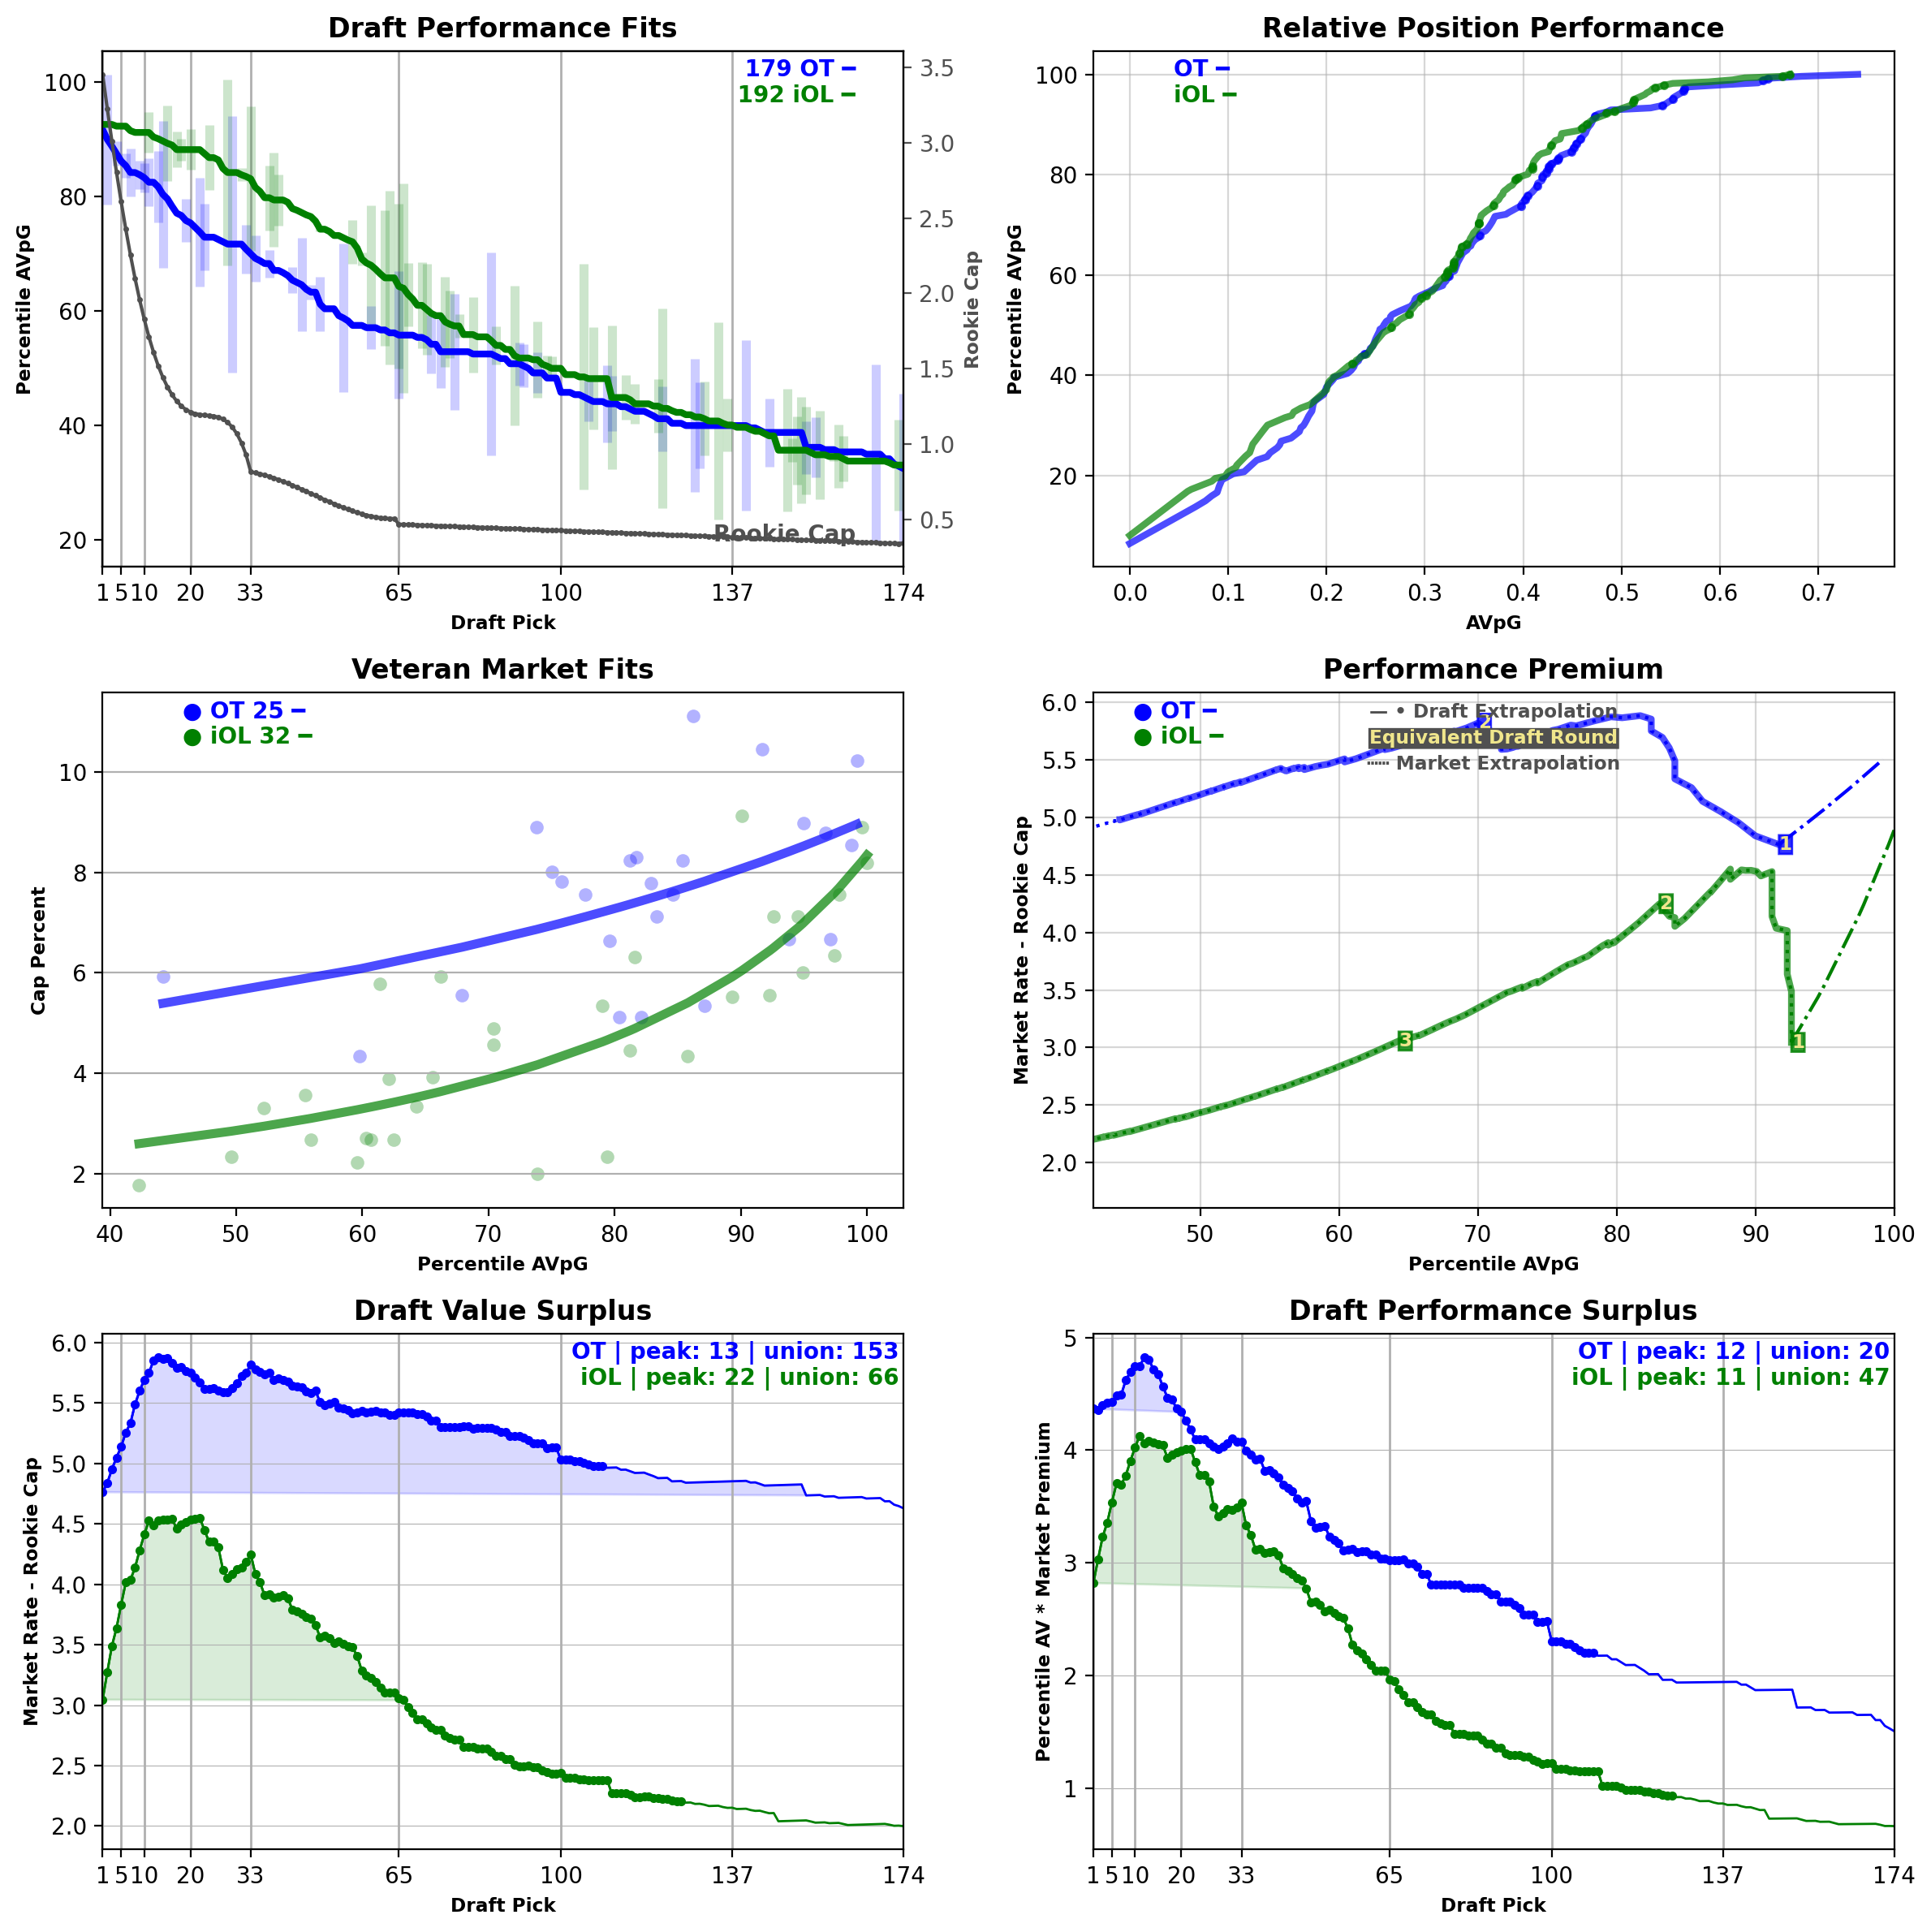

In [31]:
position_compare(ot,iol, pick_bounds=(1,174), fig_dpi=200, save=Path('comparison graphs'))

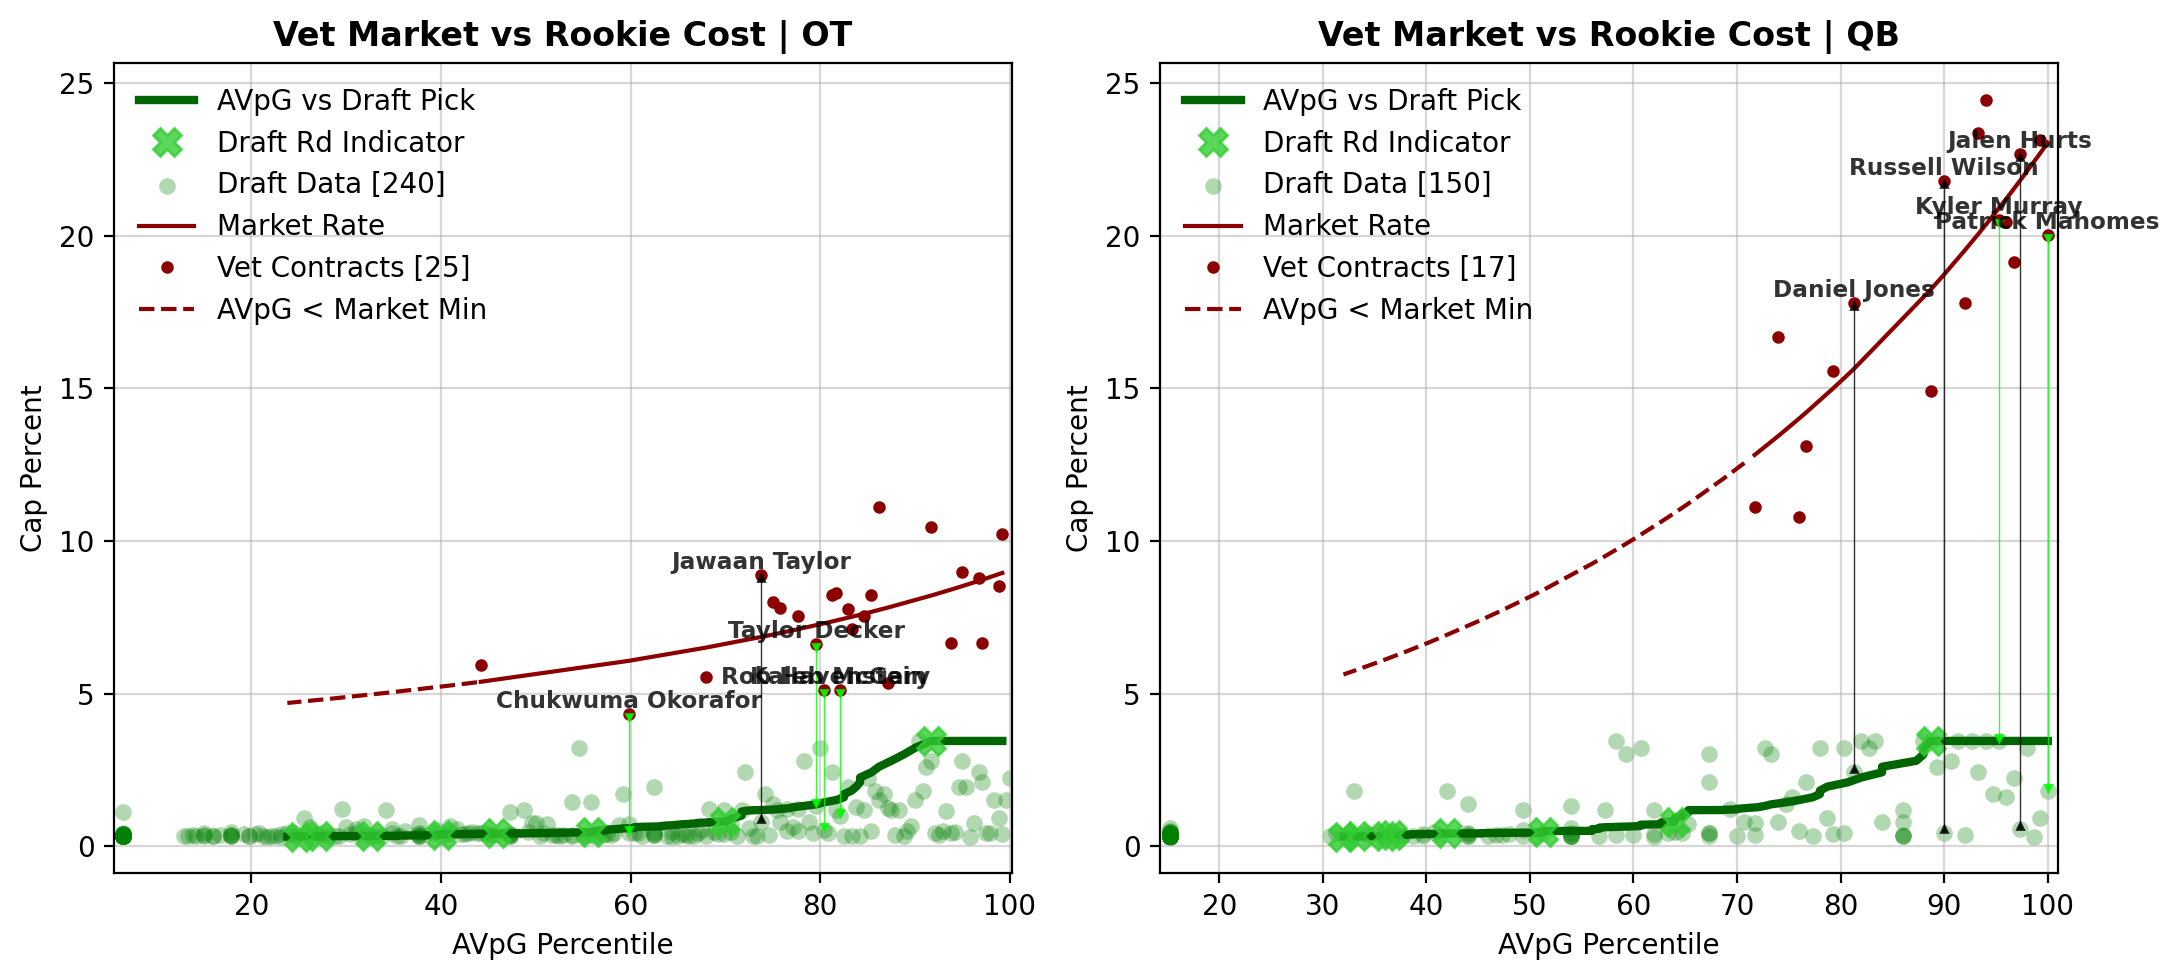

In [33]:
market_premium_compare(ot,qb, fig_dpi=200, save=Path('comparison graphs'))

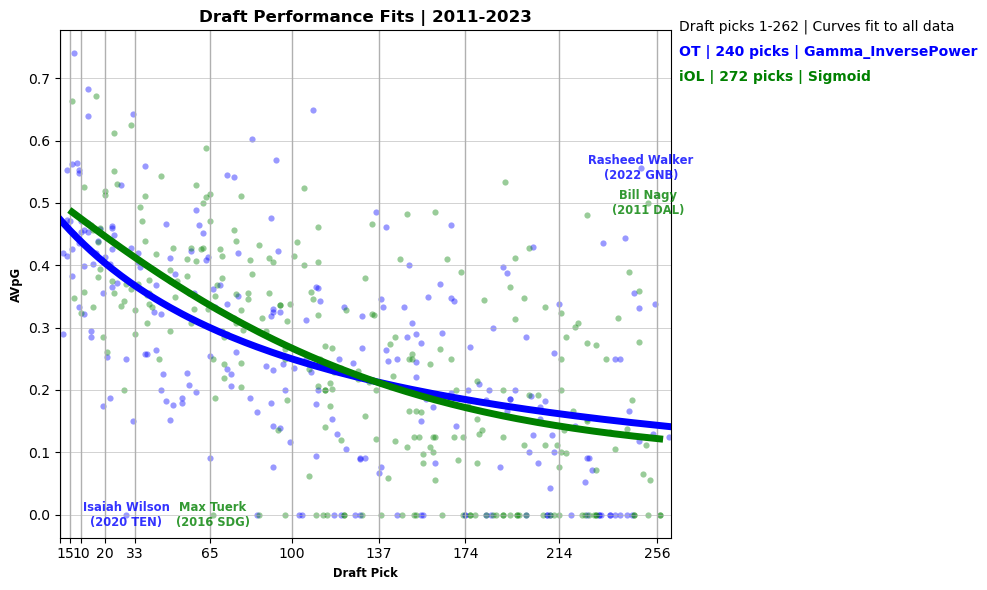

In [15]:
draft_fit_compare(ot,iol, pick_bounds=(1,262), 
                  fig_dpi=100, box=False, save=False) 

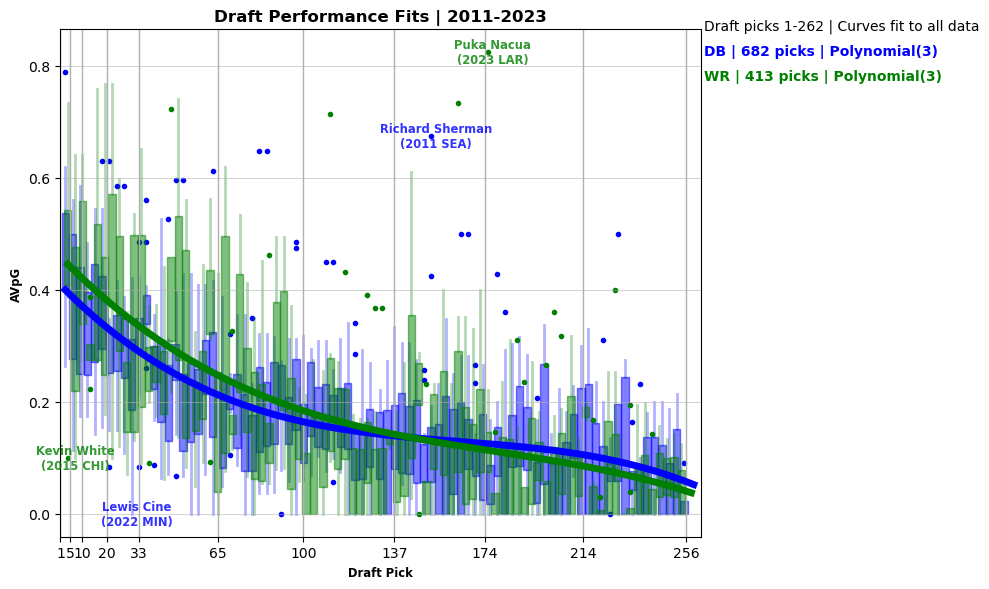

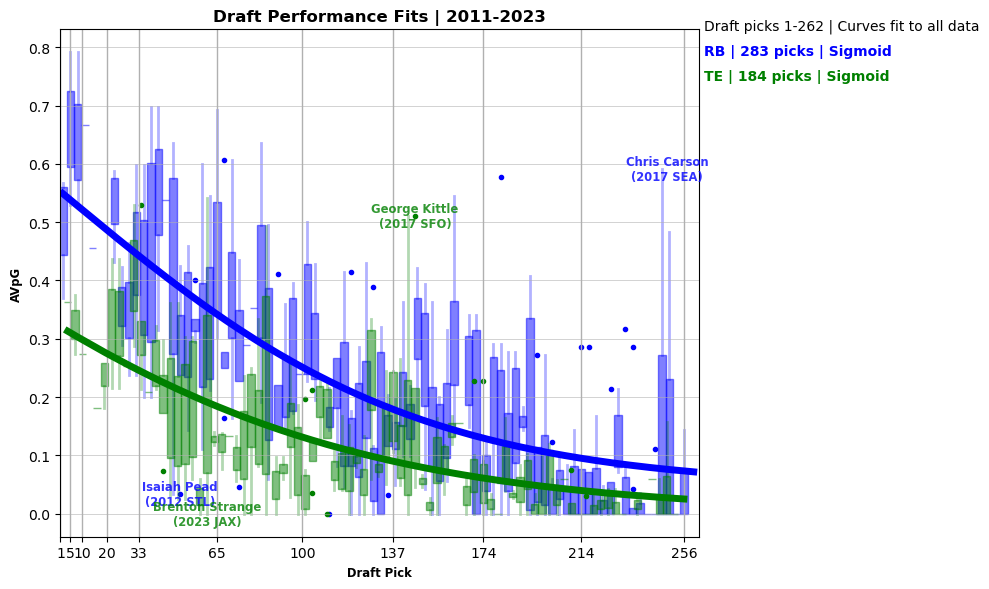

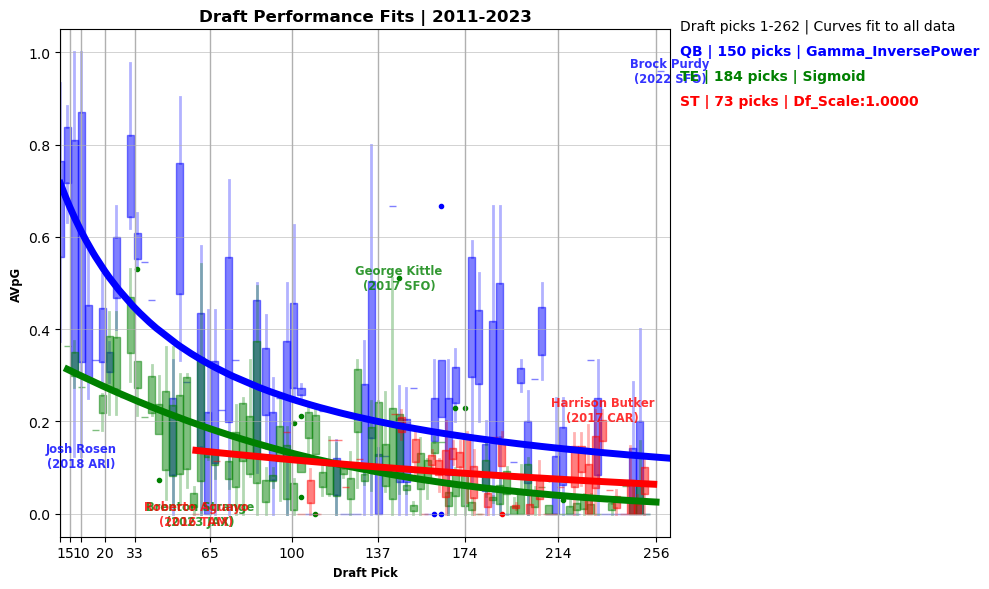

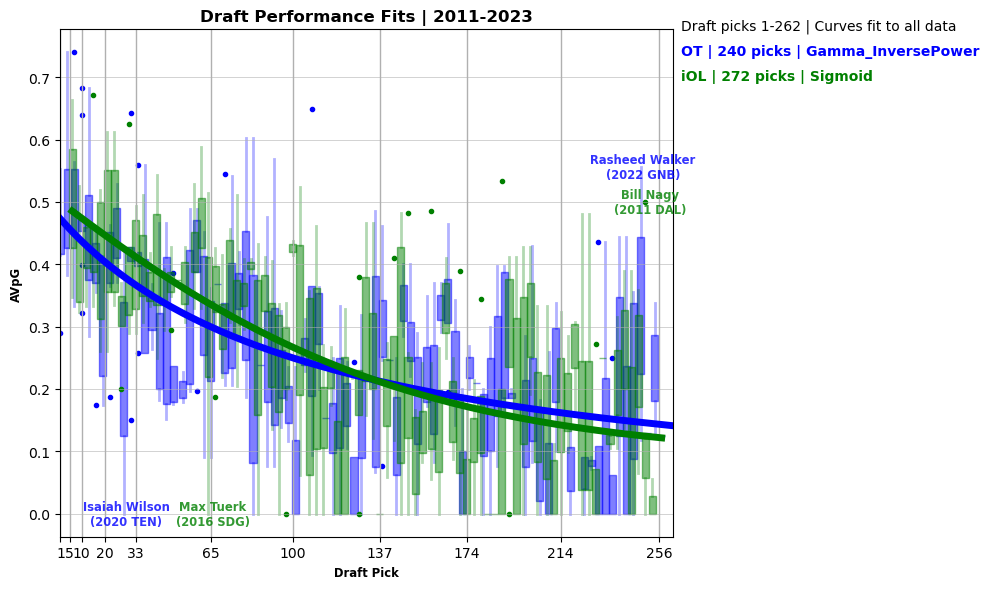

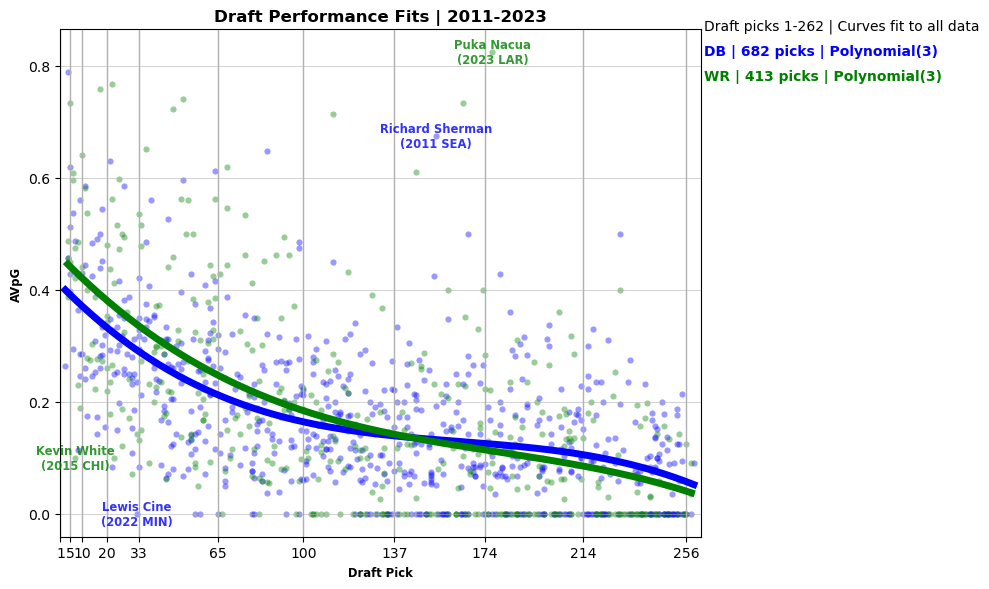

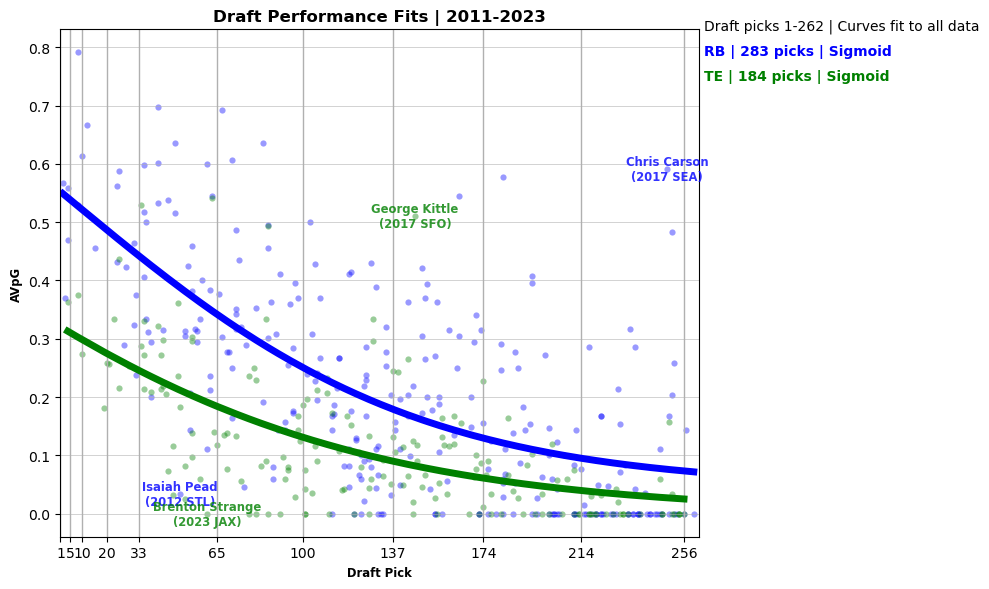

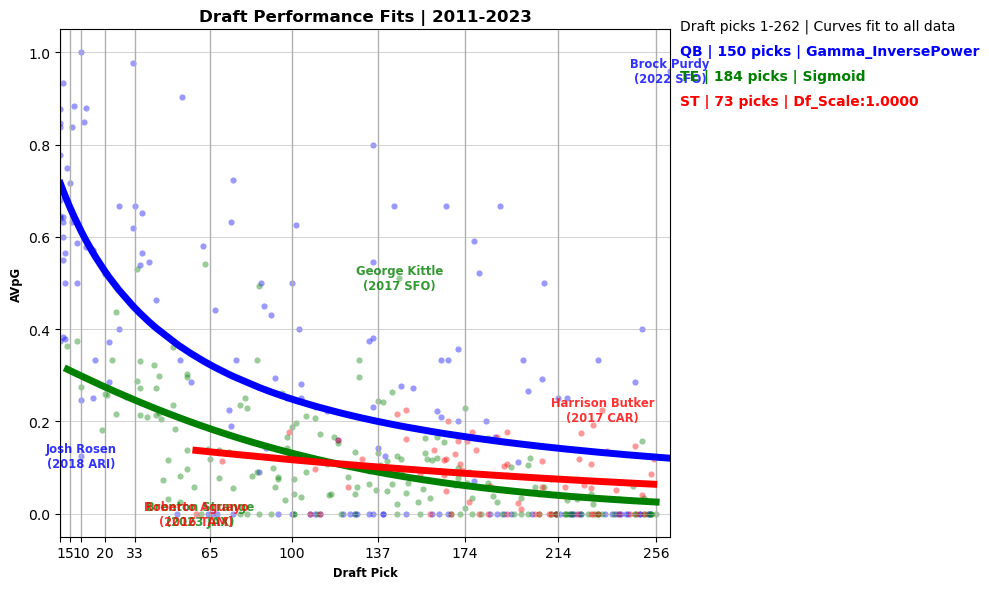

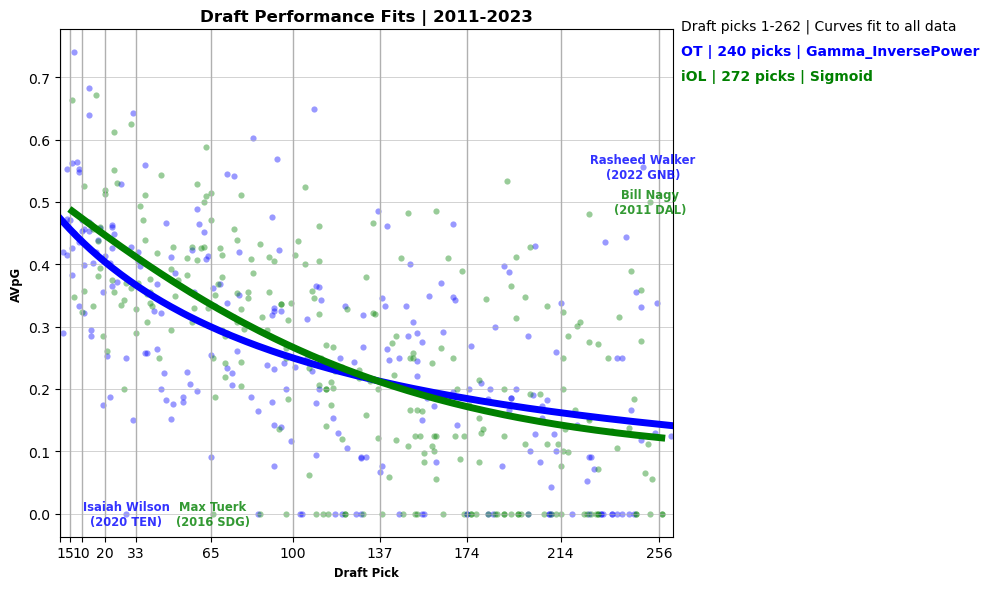

In [13]:
# for box in [True,False]:
#     draft_fit_compare(db,wr, pick_bounds=(1,262), fig_dpi=100, 
#                       box=box, save=Path('comparison graphs')) 
#     draft_fit_compare(rb,te, pick_bounds=(1,262), fig_dpi=100, 
#                       box=box, save=Path('comparison graphs')) 
#     draft_fit_compare(qb,te,st, pick_bounds=(1,262), fig_dpi=100, 
#                       box=box, save=Path('comparison graphs')) 
#     draft_fit_compare(ot,iol, pick_bounds=(1,262), fig_dpi=100, 
#                       box=box, save=Path('comparison graphs')) 